In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil

In [2]:
# Set working directory to home
os.chdir("/Users/giorgioclauser/Projects/covid_ita/")

In [3]:
# Remove old plots and create directory for new ones
dir_path = "/Users/giorgioclauser/Documents/covid_plts/abruzzo"
shutil.rmtree(dir_path)
os.mkdir(dir_path)

In [4]:
# Import national data
df_reg = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")

In [5]:
df_reg = df_reg.loc[df_reg['denominazione_regione']=='Abruzzo'].copy()

In [6]:
# Feature engineering
df_reg["prcn_tamponi_positivi_overall"] = df_reg["totale_casi"]/df_reg["tamponi"]
df_reg["prcn_tamponi_positivi_daily"] = df_reg["variazione_totale_positivi"]/(df_reg["tamponi"] - df_reg["tamponi"].shift(1))
df_reg['reference_day'] = df_reg.data.apply(lambda x: x[5:10])
df_reg['nuovi_positivi'] = df_reg['totale_positivi'] - df_reg["totale_positivi"].shift(1)
df_reg["growth_rate"] = df_reg["totale_positivi"]/df_reg["totale_positivi"].shift(1)

In [7]:
df_reg.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en,prcn_tamponi_positivi_overall,prcn_tamponi_positivi_daily,reference_day,growth_rate
1638,2020-05-12T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,222,8,230,1318,...,370,3115,50295,35241.0,NaN,NaN,0.061935,-0.043822,05-12,0.962088
1659,2020-05-13T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,214,7,221,1268,...,375,3127,51361,35898.0,NaN,NaN,0.060883,-0.055347,05-13,0.961886
1680,2020-05-14T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,215,6,221,1261,...,379,3136,52860,36844.0,NaN,NaN,0.059327,-0.004670,05-14,0.995299
1701,2020-05-15T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,205,6,211,1243,...,381,3148,54028,37587.0,NaN,NaN,0.058266,-0.023973,05-15,0.981107
1722,2020-05-16T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,195,7,202,1221,...,383,3178,55672,38681.0,NaN,NaN,0.057084,-0.018856,05-16,0.978680


In [8]:
# Giorni con decreti:
day_decreti = ['03-04', '03-08', '03-09', '03-11', '03-22']
fase2 = ['05-04']

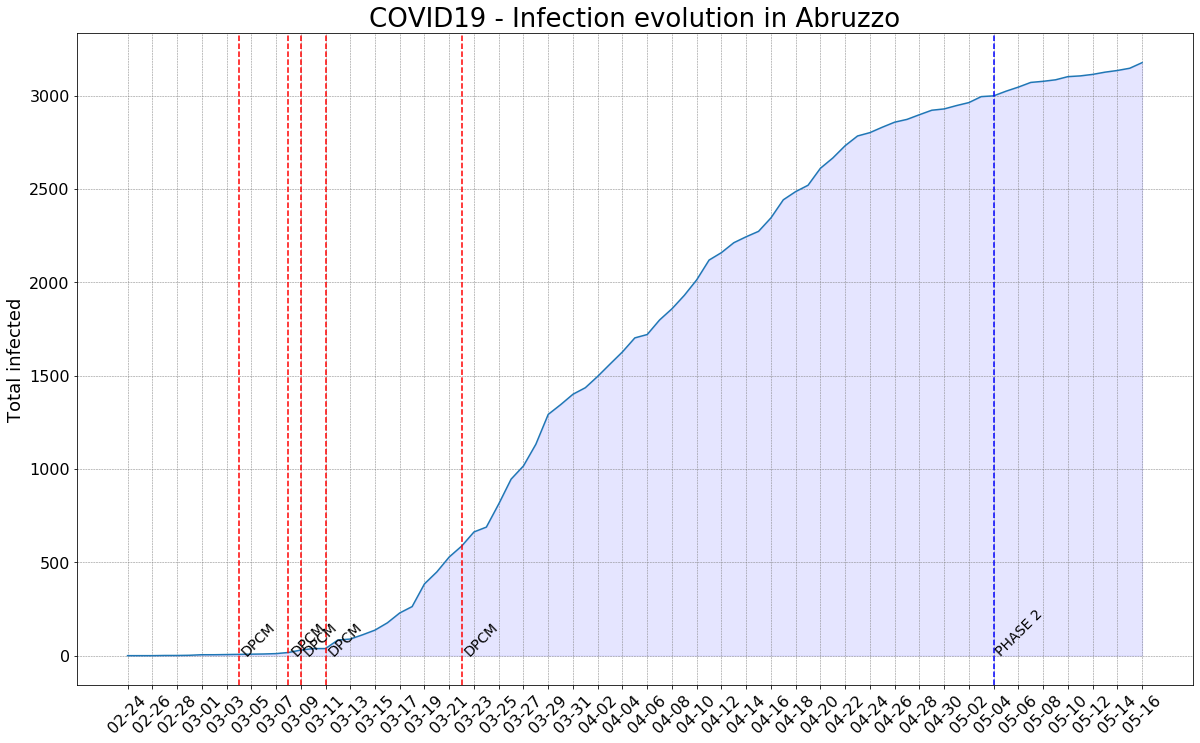

In [9]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_casi",
                  data=df_reg)
plt.fill_between(x='reference_day', y1='totale_casi', y2=0 ,data=df_reg, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Total infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection evolution in Abruzzo', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::2])
plt.savefig(f"{dir_path}/infection_evolution_abz.png")
plt.show()

In [10]:
def get_trend(series):
    from pandas import datetime
    from sklearn.linear_model import LinearRegression
    from matplotlib import pyplot
    import numpy
     
    def parser(x):
        return datetime.strptime('190'+x, '%Y-%m')
     
    series = series.dropna()
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = numpy.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    return trend

In [11]:
# Generate plot
df_gr = df_reg[["reference_day", "growth_rate"]].dropna().copy()
df_gr["growth_rate"] = df_gr.growth_rate.rolling(window=4).mean()
df_gr.dropna(inplace=True)
df_gr = df_reg[["reference_day", "growth_rate"]].dropna().copy()

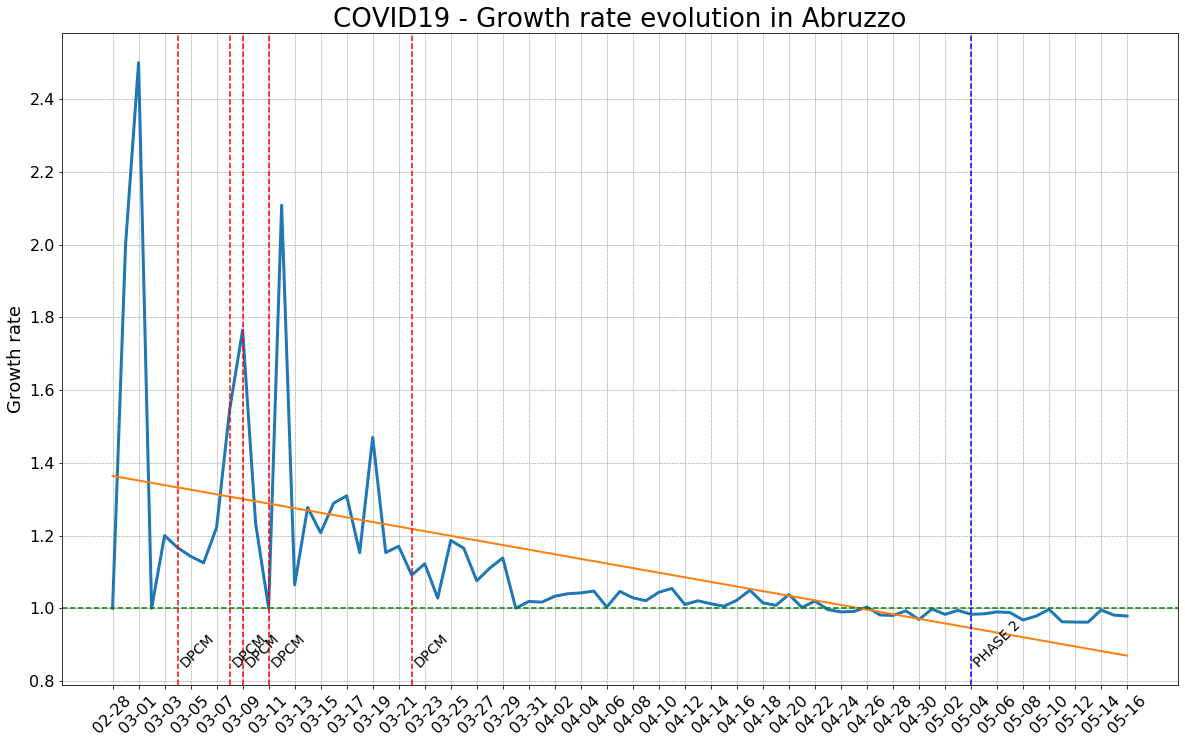

In [12]:
# Generate plot
df_gr = df_reg[["reference_day", "growth_rate"]].dropna().copy()
df_gr["growth_rate"] = df_gr.growth_rate.rolling(window=4).mean()
df_gr.dropna(inplace=True)
df_gr = df_reg[["reference_day", "growth_rate"]].dropna().copy()
df_gr = df_gr.iloc[1:,:].copy()
df_gr["trend"] = get_trend(df_gr["growth_rate"])
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="growth_rate",
                  data=df_gr, lw=3)
ax = sns.lineplot(x="reference_day", y="trend",
                  data=df_gr, lw=2)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Growth rate', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Growth rate evolution in Abruzzo', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
#plt.ylim(bottom=-2, top=5)
ax.axhline(1, ls='--', color='green', lw=1.5)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .84,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .84,'PHASE 2', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::2])
plt.savefig(f"{dir_path}/growth_rate_abz.png")
plt.show()

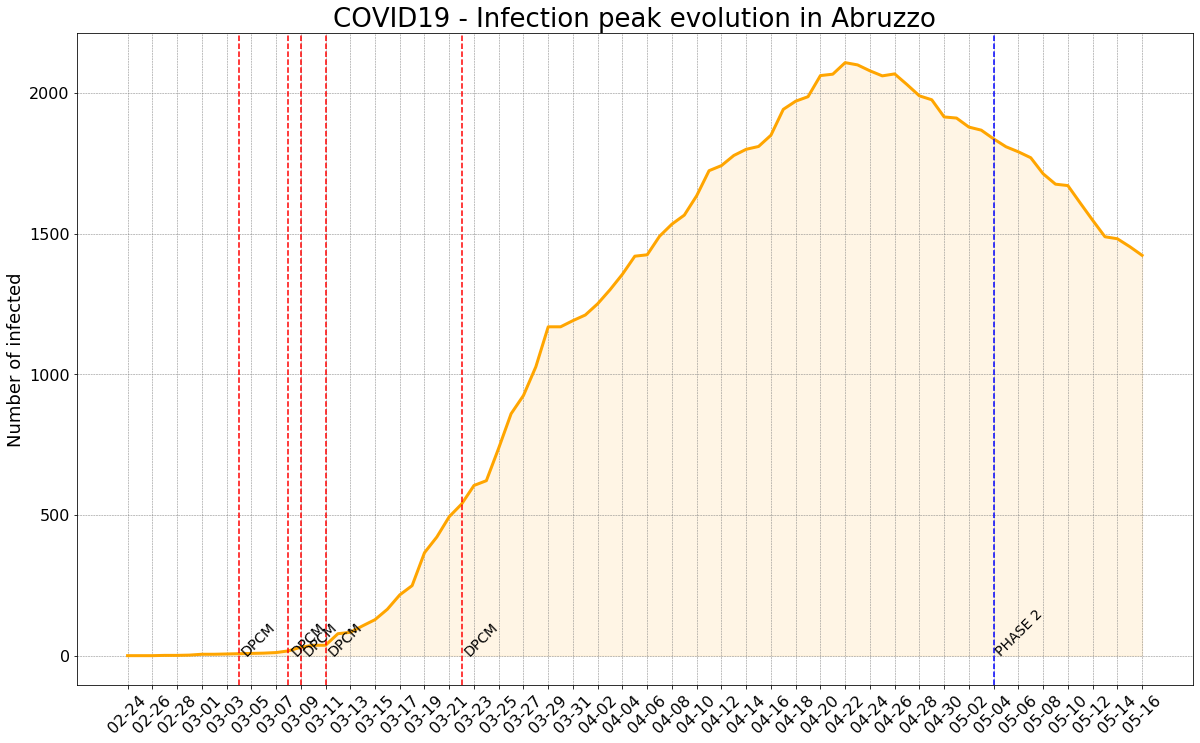

In [13]:
# What does the peak look like?
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_positivi",
                  data=df_reg, lw=3, color='orange')
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.fill_between(x='reference_day', y1='totale_positivi', y2=0 ,data=df_reg, color='orange', alpha=.1)
plt.ylabel('Number of infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection peak evolution in Abruzzo', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .5,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::2])
plt.savefig(f"{dir_path}/peak_evolution_abz.png")
plt.show()

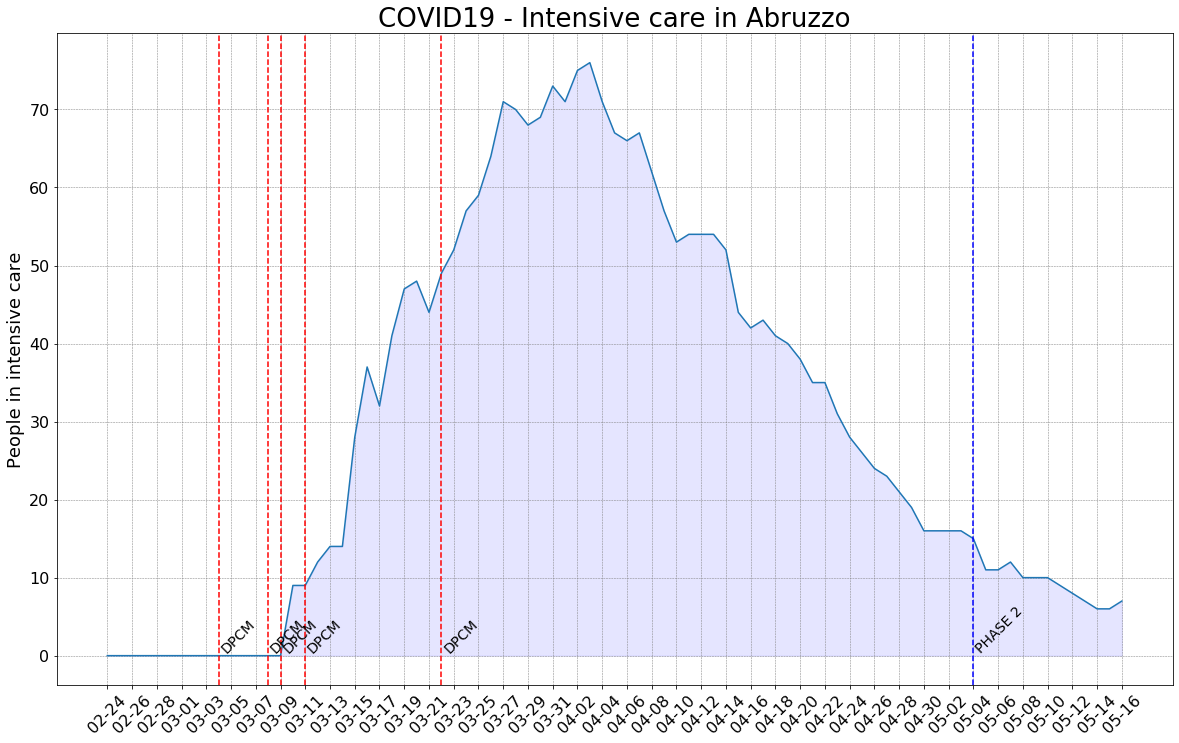

In [14]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="terapia_intensiva",
                  data=df_reg)
plt.fill_between(x='reference_day', y1='terapia_intensiva', y2=0 ,data=df_reg, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('People in intensive care', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Intensive care in Abruzzo', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::2])
plt.savefig(f"{dir_path}/intensive_care_abz.png")
plt.show()